### Predicting MLB Player Salaries: A Batting Performance Analysis
---
## Predictive Modeling for Major League Baseball Player Salaries

Author: Hector Guerrero

---

### Project Overview

In this project, "Predicting MLB Player Salaries: A Batting Performance Analysis," we aim to build a model that accurately predicts Major League Baseball player salaries. However, before we delve into model building, we need to explore and understand the data we have.

### Table of contents

1. [Introduction](#introduction)
2. [Data Loading and Preprocessing](#data-loading-and-preprocessing)    
    - [2.1 Data Loading](#load-data)    
    - [2.2 Train-Test Split](#train-test-split)    
    - [2.3 Data Preprocessing: Scaling and Encoding](#data-preprocessing:-scaling-and-encoding)
3. [Baseline Model: Linear Regression](#baseline-model:-linear-regression)
4. [Advanced Models](#advanced-models)    
    - [4.1 Ridge Regression](#ridge-regression)    
    - [4.2 Lasso Regression](#lasso-regression)    
    - [4.3 Decision Trees](#decision-trees)    
    - [4.4 Random Forest](#random-forest)    
    - [4.5 Gradient Boosting](#gradient-boosting)
5. [Feature Importance and Interpretation](#feature-importance-and-interpretation)
6. [Conclusion](#conclusion)

In [140]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## 1. Introduction <a id='introduction'></a>
In this notebook, we will be predicting Major League Baseball player salaries. The aim is not only to build models that accurately predict salaries, but also to derive insights on what aspects of the game most significantly influence a player's earnings. For this purpose, we will start with a simple linear regression model as our baseline, and then explore more complex models such as Ridge and Lasso Regression, Decision Trees, Random Forests, and Gradient Boosting. Each model will be evaluated based on its predictive accuracy, and its interpretability will be assessed to understand the influence of various features on a player's salary. 

## 2. Data Loading and Preprocessing <a id='data-loading-and-preprocessing'></a>
### 2.1. Data Loading <a id='load-data'></a>

In [40]:
# Load data
df = pd.read_csv('baseball_salaries_top_features.csv')

In [71]:
df.shape

(22010, 18)

In [72]:
df.dtypes

playerID            object
adjusted_salary    float64
age                float64
career_length      float64
bats                object
throws              object
POS                 object
teamName            object
career_PA            int64
Career_R             int64
Career_H             int64
Career_HR            int64
career_RBI           int64
Career_BB            int64
Career_SO            int64
Career_IBB           int64
career_TB            int64
career_WAR         float64
dtype: object

In [7]:
df.sample(5)

,playerID,adjusted_salary,age,career_length,bats,throws,POS,teamName,career_PA,Career_R,Career_H,Career_HR,career_RBI,Career_BB,Career_SO,Career_IBB,career_TB,career_WAR
12260,sandoda01,503580.0,27.0,1.0,B,R,2B,Philadelphia Phillies,45,2,8,0,4,4,4,0,9,-0.25
1884,danieka01,488400.0,24.0,2.0,L,R,OF,Cincinnati Reds,1226,202,325,50,151,169,186,22,550,12.02
12495,kotsama01,10780000.0,30.0,9.0,L,L,OF,Oakland Athletics,5300,644,1369,102,540,411,569,22,2022,23.71
10423,sardida01,504000.0,24.0,0.0,R,R,C,Cincinnati Reds,2,0,0,0,0,0,1,0,0,-0.05
14550,betemwi01,1885000.0,27.0,8.0,B,R,3B,Chicago White Sox,1275,147,295,42,154,113,327,10,494,0.77


In [41]:
# # For each player, move the adjusted salary one year into the future
# df['adjusted_salary'] = df.groupby('playerID')['adjusted_salary'].shift(-1)

# # Drop adjusted_salary
# df.drop('adjusted_salary', axis=1, inplace=True)

# Drop playerID
df.drop('playerID', axis=1, inplace=True)

### 2.2 Train-Test Split <a id='train-test-split'></a>

In [42]:
# Features and target
X = df.drop(columns=['adjusted_salary'])
y = df['adjusted_salary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splits to dataframe
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


In [43]:
X_train.shape, X_test.shape

((17608, 16), (4402, 16))

In [44]:
X_train.head()

,age,career_length,bats,throws,POS,teamName,career_PA,Career_R,Career_H,Career_HR,career_RBI,Career_BB,Career_SO,Career_IBB,career_TB,career_WAR
14485,33.0,8.0,R,R,OF,Baltimore Orioles,2274,306,532,22,122,222,350,1,732,8.77
21075,22.0,0.0,R,R,SS,Cincinnati Reds,68,4,13,0,2,1,26,0,13,-0.67
14911,24.0,1.0,L,L,OF,Texas Rangers,647,90,170,7,62,34,87,0,214,2.27
12845,30.0,6.0,R,R,OF,Detroit Tigers,2658,338,628,104,388,165,519,10,1093,4.31
487,29.0,4.0,R,R,OF,Houston Astros,164,14,26,5,21,11,25,0,49,-0.53


In [11]:
y_train.shape, y_test.shape

((17608,), (4402,))

### 2.3 Data Preprocessing: Scaling and Encoding <a id='data-preprocessing:-scaling-and-encoding'></a>

In [46]:
# Columns to encode
num_cols = ['age', 'career_length', 'career_PA', 'Career_R', 'Career_H', 'Career_HR', 'career_RBI', 'Career_BB', 'Career_SO', 'Career_IBB', 'career_TB', 'career_WAR']
cat_cols = ['bats', 'throws', 'POS', 'teamName']

len(num_cols) + len(cat_cols) == len(df.columns) - 1

True

In [47]:
# Define a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)])

# Fit and transform the training and test sets
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Category names
ohe_cats = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# Combine the lists
feature_names = num_cols + list(ohe_cats)

# Convert to dataframe
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [48]:
X_train.shape, X_test.shape

((17608, 50), (4402, 50))

In [82]:
pd.set_option('display.max_columns', None)
X_train.head(5)

,age,career_length,career_PA,Career_R,Career_H,Career_HR,career_RBI,Career_BB,Career_SO,Career_IBB,career_TB,career_WAR,bats_L,bats_R,throws_R,POS_2B,POS_3B,POS_C,POS_OF,POS_P,POS_SS,teamName_Atlanta Braves,teamName_Baltimore Orioles,teamName_Boston Red Sox,teamName_Chicago Cubs,teamName_Chicago White Sox,teamName_Cincinnati Reds,teamName_Cleveland Guardians,teamName_Colorado Rockies,teamName_Detroit Tigers,teamName_Houston Astros,teamName_Kansas City Royals,teamName_Los Angeles Angels,teamName_Los Angeles Dodgers,teamName_Miami Marlins,teamName_Milwaukee Brewers,teamName_Minnesota Twins,teamName_New York Mets,teamName_New York Yankees,teamName_Oakland Athletics,teamName_Philadelphia Phillies,teamName_Pittsburgh Pirates,teamName_San Diego Padres,teamName_San Francisco Giants,teamName_Seattle Mariners,teamName_St. Louis Cardinals,teamName_Tampa Bay Rays,teamName_Texas Rangers,teamName_Toronto Blue Jays,teamName_Washington Nationals
0,1.154435,0.696549,0.139613,0.199112,0.106300,-0.386830,-0.360556,0.209330,0.108852,-0.483054,-0.014945,0.034336,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.517236,-1.149730,-0.836551,-0.788277,-0.809703,-0.655186,-0.765434,-0.733684,-0.821324,-0.516972,-0.799747,-0.619928,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.031478,-0.918945,-0.580341,-0.507100,-0.532608,-0.569800,-0.562995,-0.592872,-0.646198,-0.516972,-0.580351,-0.416164,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.425797,0.234979,0.309535,0.303736,0.275734,0.613406,0.536925,-0.033891,0.594036,-0.177796,0.379093,-0.274776,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.182918,-0.226591,-0.794071,-0.755582,-0.786759,-0.594196,-0.701328,-0.691014,-0.824195,-0.516972,-0.760452,-0.610225,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Baseline Model: Linear Regression <a id='baseline-model:-linear-regression'></a>


Linear regression is a good starting point as a baseline model since it is simple, fast, and provides a first approximation of the relationship between the target and features.

In [49]:
# Pipeline
pipeline = Pipeline(steps=[
    ('model', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
train_preds = pipeline.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)

test_preds = pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)

train_rmse, test_rmse = np.sqrt(train_mse), np.sqrt(test_mse)

# Rsquared
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')


Train RMSE: 3353380.094016173
Test RMSE: 3303897.510626897
Train R2: 0.5744438986858085
Test R2: 0.6005761807145622


Our model can explain about 57.4% of the variation in the training set and about 60.0% of the variation in the test set. The fact that the R^2 value for the test set is slightly higher than for the training set may suggest that the model is generalizing well and not overfitting to the training data. However, there's still quite a bit of room for improvement.

In [50]:
# Coefficients
coefficients = pipeline.named_steps['model'].coef_

# Create a dataframe
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

coef_df.sort_values('coefficient', ascending=False)

,feature,coefficient
10,career_TB,1.219524e+07
4,Career_H,6.126902e+06
8,Career_SO,2.624176e+06
7,Career_BB,1.218268e+06
11,career_WAR,1.066148e+06
38,teamName_New York Yankees,9.830664e+05
20,POS_SS,8.360365e+05
33,teamName_Los Angeles Dodgers,7.436087e+05
45,teamName_St. Louis Cardinals,6.585932e+05
17,POS_C,6.019658e+05


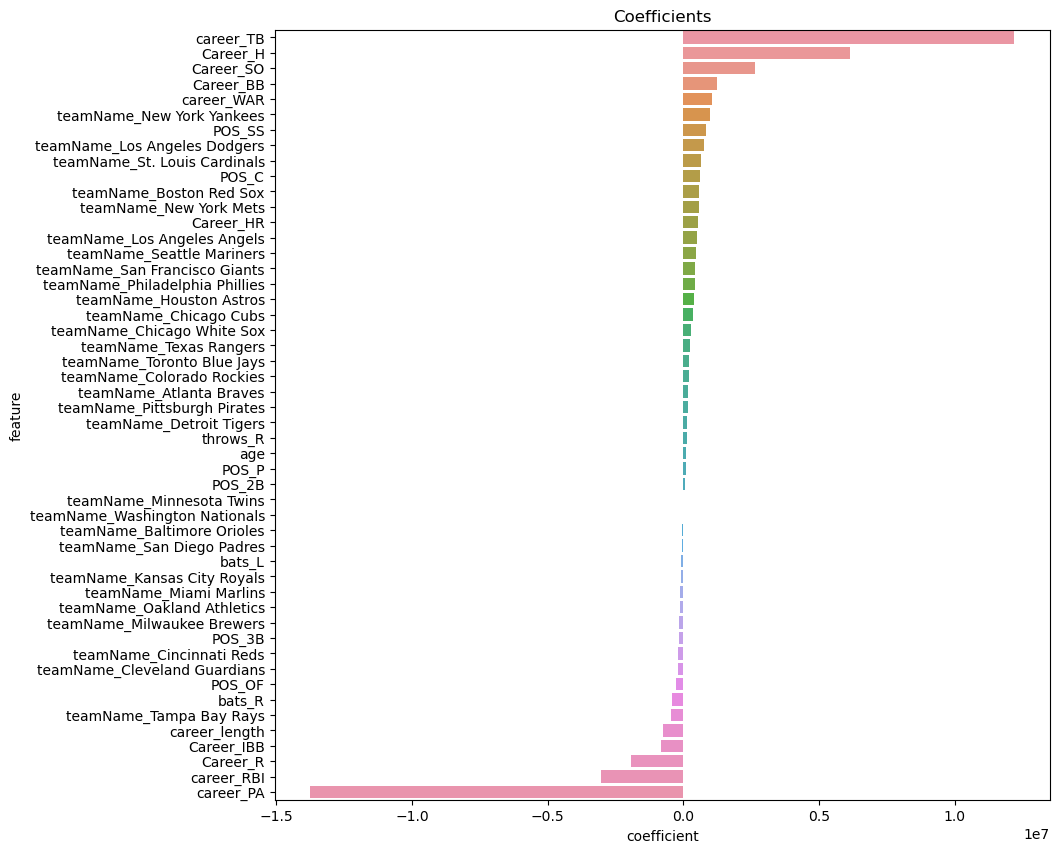

In [51]:
# Plot the coefficients
plt.figure(figsize=(10, 10))
sns.barplot(data=coef_df.sort_values('coefficient', ascending=False), x='coefficient', y='feature')
plt.title('Coefficients')
plt.show()


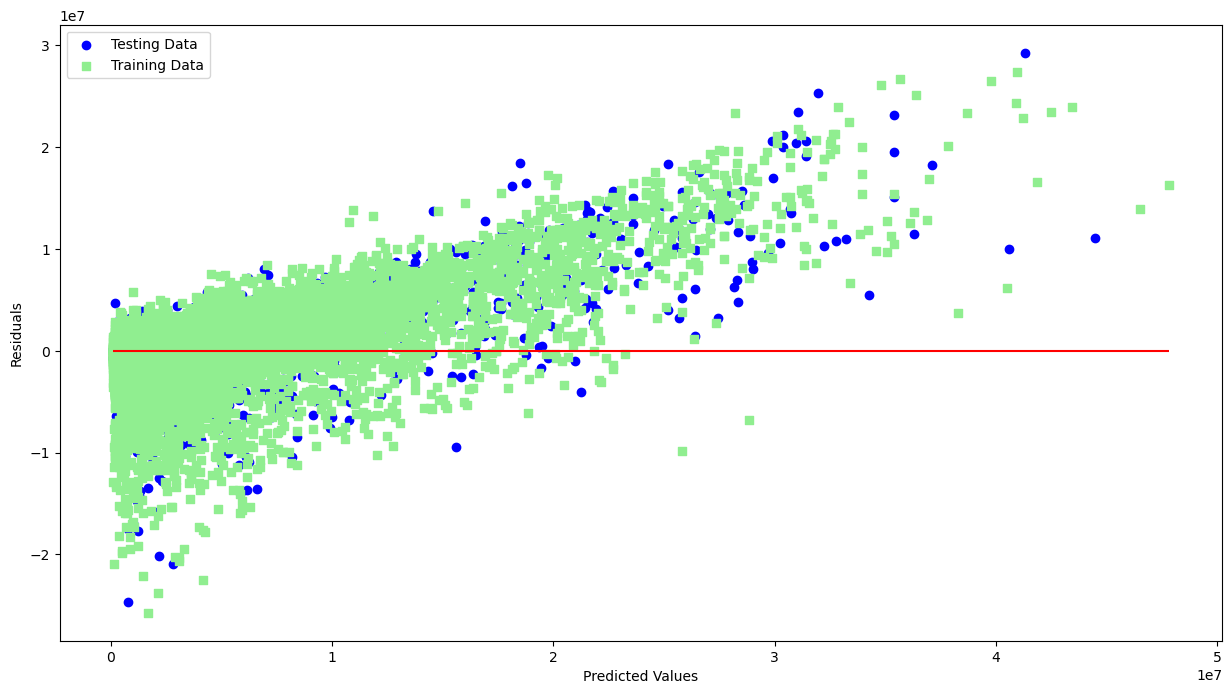

In [52]:
# Residuals
plt.figure(figsize=(15, 8))
plt.scatter(y_test, y_test - test_preds, c="blue", marker="o", label="Testing Data")
plt.scatter(y_train, y_train - train_preds, c="lightgreen", marker="s", label="Training Data")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=y.min(), xmax=y.max(), color="red")
plt.show()



The model's performance varies across different salary levels. Ideally, we want a random scatter, indicating consistent model performance across all levels. This suggests the need for model improvements or alternative models to better capture patterns in the data.

## 4. Advanced Models <a id='advanced-models'></a>
### 4.1 Ridge Regression <a id='ridge-regression'></a>

Ridge regression is a type of linear regression that includes a regularization term. Regularization helps prevent overfitting by adding a penalty to the size of the coefficients, which can be particularly useful when dealing with datasets with many features.

In [53]:
# Pipeline
ridge_pipe = Pipeline(steps=[('model', Ridge())])

In [54]:
# Param grid
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}


In [55]:
# GridSearchCV
grid_search = GridSearchCV(ridge_pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

# Predict
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

# Evaluate
print("Train R^2: {}".format(grid_search.score(X_train, y_train)))
print("Test R^2: {}".format(grid_search.score(X_test, y_test)))
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'classifier__alpha': 1}
Train R^2: 0.5744121743715713
Test R^2: 0.6003124386708516
Train RMSE: 3353505.085410885
Test RMSE: 3304988.122707601


Ridge regression performed very similarly to the baseline linear regression model. The R2 score was the same (0.600), and the RMSE was slightly higher (about $3.3 million). This suggests that the regularization term didn't significantly improve the model's performance.

### 4.2 Lasso Regression <a id=lasso-regression></a>

Like Ridge, Lasso regression also includes a regularization term, but it can make some of the coefficients exactly zero. This means that it can serve as a feature selection method – it can help identify which features are most important in predicting the target variable.

In [199]:
# Pipeline
lasso_pipe = Pipeline(steps=[('model', Lasso())])

In [200]:
# Grid
grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Grid search cross validation
lasso_cv = GridSearchCV(lasso_pipe, grid, cv=5)

# Fit it to the data
lasso_cv.fit(X_train, y_train)

# Predict on the test set
lasso_pred = lasso_cv.predict(X_test)

# Print best parameters and score
print("Tuned Lasso Regression Parameters: {}".format(lasso_cv.best_params_))

print("Train R^2: {}".format(lasso_cv.score(X_train, y_train)))
print("Test R^2: {}".format(lasso_cv.score(X_test, y_test)))
print('Train RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, lasso_cv.predict(X_train)))))
print('Test RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, lasso_cv.predict(X_test)))))

c:\Users\Hector G. Guerrero\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.873e+16, tolerance: 3.734e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\Hector G. Guerrero\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.080e+16, tolerance: 3.770e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\Hector G. Guerrero\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

Tuned Lasso Regression Parameters: {'model__alpha': 1000}
Train R^2: 0.5726010363639522
Test R^2: 0.5981595401986938
Train RMSE: 3360633.123475055
Test RMSE: 3313877.251020241


c:\Users\Hector G. Guerrero\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.207e+16, tolerance: 4.653e+13
  model = cd_fast.enet_coordinate_descent(


In [204]:
fitted_lasso = lasso_cv.best_estimator_.named_steps['model']
coefficients = fitted_lasso.coef_
feature_importances_lasso = pd.Series(coefficients, index = X_train.columns)
feature_importances_lasso = feature_importances_lasso.sort_values(ascending = False)
feature_importances_lasso

Career_H                          1.187051e+07
Career_SO                         2.803997e+06
career_TB                         2.411091e+06
Career_HR                         2.338175e+06
career_WAR                        1.082466e+06
Career_BB                         8.662694e+05
POS_SS                            8.267248e+05
teamName_New York Yankees         6.808645e+05
POS_C                             6.106332e+05
teamName_Los Angeles Dodgers      5.392108e+05
teamName_St. Louis Cardinals      4.287746e+05
teamName_Boston Red Sox           4.135284e+05
teamName_New York Mets            3.579317e+05
teamName_Los Angeles Angels       2.556184e+05
teamName_Philadelphia Phillies    2.522967e+05
teamName_Seattle Mariners         2.376605e+05
teamName_San Francisco Giants     2.360238e+05
teamName_Houston Astros           1.822150e+05
teamName_Chicago Cubs             1.695852e+05
throws_R                          9.027604e+04
POS_2B                            7.467537e+04
age          

Lasso regression had a slightly lower R2 score (0.598) and a slightly higher RMSE ($3.3 million) compared to the other linear models. This might be due to the fact that some of the coefficients were shrunk to zero, effectively excluding some features from the model.

### 4.3 Decision Trees <a id='decision-trees'></a>
Decision trees are more powerful models that can capture non-linear relationships and interactions between variables. They are also the building blocks of more advanced models such as random forests and gradient boosting machines (GBMs).

In [58]:
# Pipeline
dt_pipe = Pipeline(steps=[('classifier', DecisionTreeRegressor(random_state=42))])

In [63]:
# Param grid
param_grid = {
    'classifier__max_depth': list(range(1, 31)),
    'classifier__min_samples_leaf': [1, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10, 15],
}

# Grid search
grid_search = GridSearchCV(dt_pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit
grid_search.fit(X_train, y_train)

# Best params
print('Best params:', grid_search.best_params_)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


Best params: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}


In [64]:
# Evaluate
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

print('Train R2:', r2_score(y_train, y_train_pred))
print('Test R2:', r2_score(y_test, y_test_pred))

Train RMSE: 2823064.074387091
Test RMSE: 3188294.561381646
Train R2: 0.6983990340216568
Test R2: 0.6280387458826173


The decision tree model had a higher R2 score (0.628) and a lower RMSE ($3.2 million) compared to the linear models, indicating better performance.

### 4.4 Random Forest <a id='random-forest'></a>

Random forest is an ensemble method that combines multiple decision trees to make predictions. It generally performs better than a single decision tree as it reduces overfitting by averaging the results of many trees. It is also more robust to outliers and noise than a single decision tree.


In [67]:
# pipeline
rf_pipe = Pipeline(steps=[('classifier', RandomForestRegressor(random_state=42))])

In [69]:
# Param grid
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
}

# Grid search
rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit
rf_grid.fit(X_train, y_train)


# Best params and score
print(f'Best params: {rf_grid.best_params_}')
print(f'Best score: {rf_grid.best_score_}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best score: 0.7302681197101067


In [70]:
# Evaluate
y_test_pred = rf_grid.predict(X_test)
y_train_pred = rf_grid.predict(X_train)


#RMSE
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

#R2
print('Train R2:', r2_score(y_train, y_train_pred))
print('Test R2:', r2_score(y_test, y_test_pred))


Train RMSE: 963427.0376815721
Test RMSE: 2681138.6582514113
Train R2: 0.9648739821291942
Test R2: 0.7369614657162469


The random forest model significantly outperformed the other models. It had a high R2 score of 0.737 and a relatively low RMSE of about $2.7 million on the test set.

In [91]:
# Features Importance
fitted_rf = rf_grid.best_estimator_.named_steps['classifier']

importances = fitted_rf.feature_importances_

# Match feature importances to the features
feature_importances = pd.Series(importances, index = X_train.columns)

# Sort the feature importances
feature_importances = feature_importances.sort_values(ascending = False)

# Print out the feature importances
feature_importances

Career_HR                         0.234838
career_WAR                        0.218700
career_TB                         0.190691
career_length                     0.055082
Career_SO                         0.036573
age                               0.035587
career_RBI                        0.032333
Career_IBB                        0.031640
Career_R                          0.028355
Career_BB                         0.025237
career_PA                         0.019777
Career_H                          0.016878
teamName_New York Yankees         0.006803
POS_C                             0.004531
teamName_Detroit Tigers           0.003766
POS_OF                            0.003482
bats_R                            0.003399
POS_SS                            0.003099
teamName_Boston Red Sox           0.002866
teamName_Baltimore Orioles        0.002784
bats_L                            0.002562
throws_R                          0.002561
teamName_Los Angeles Dodgers      0.002462
teamName_Lo

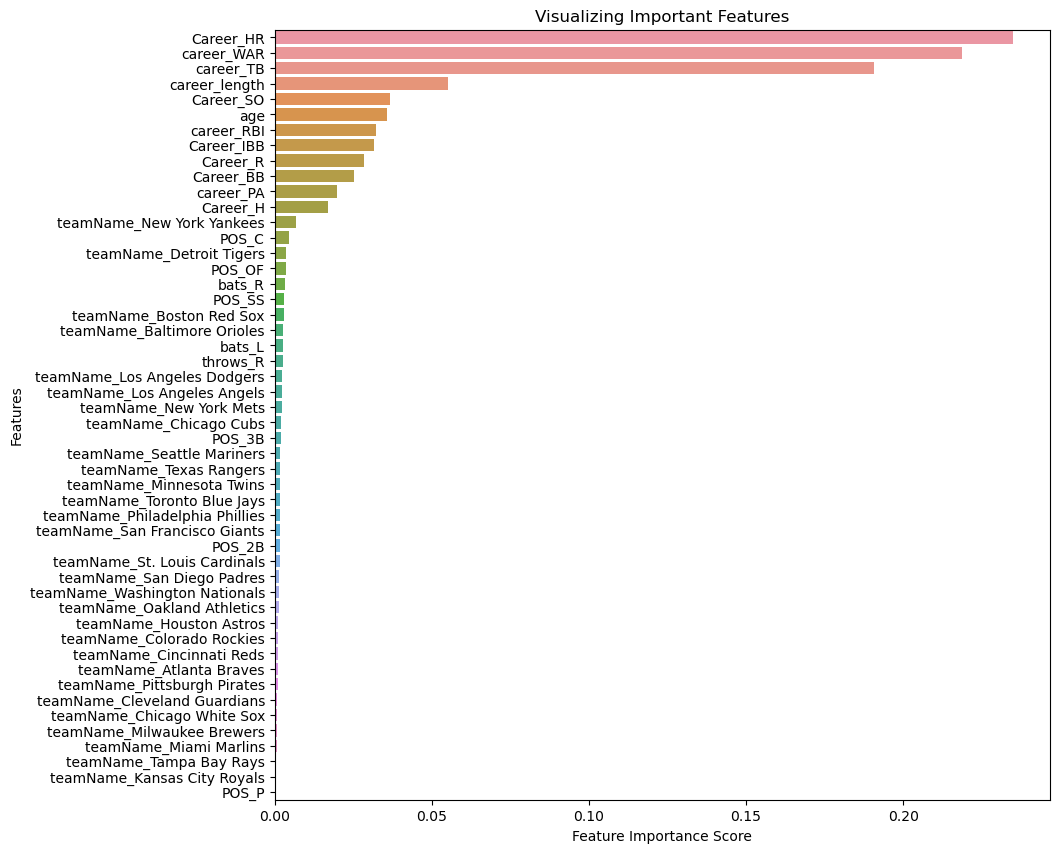

In [92]:
# Plot feature_importances
plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### 4.5 Gradient Boosting Regressor <a id='gradient-boosting'></a>

Gradient boosting is another ensemble method that builds many decision trees in a sequential manner. Each tree learns from the mistakes of the previous trees. 

In [93]:
# Pipeline
gb_pipe = Pipeline(steps=[('model', GradientBoostingRegressor(random_state=42))])

In [94]:
# Param grid
gb_param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 150, 200, 250],
    'model__max_depth': [2, 3, 4, 5],
}

# Grid search
gb_grid = GridSearchCV(estimator=gb_pipe, param_grid=gb_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit
gb_grid.fit(X_train, y_train)

# Best params and best score
print(f'Best params: {gb_grid.best_params_}')
print(f'Best score: {gb_grid.best_score_}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 250}
Best score: 0.7403784339171737


In [95]:
# Evaluate
y_test_pred = gb_grid.predict(X_test)
y_train_pred = gb_grid.predict(X_train)


#RMSE
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

#R2
print('Train R2:', r2_score(y_train, y_train_pred))
print('Test R2:', r2_score(y_test, y_test_pred))

Train RMSE: 1467343.3662539881
Test RMSE: 2628207.551865914
Train R2: 0.918519297727543
Test R2: 0.7472447737246791


The Gradient Boosting model had the best performance, with an R2 score of 0.747 and an RMSE of about $2.6 million on the test set. This means that about 74.7% of the variance in the salaries can be explained by the model, and the predictions are typically off by about $2.6 million.

C:\Users\Hector G. Guerrero\AppData\Local\Temp\ipykernel_10616\2588676357.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


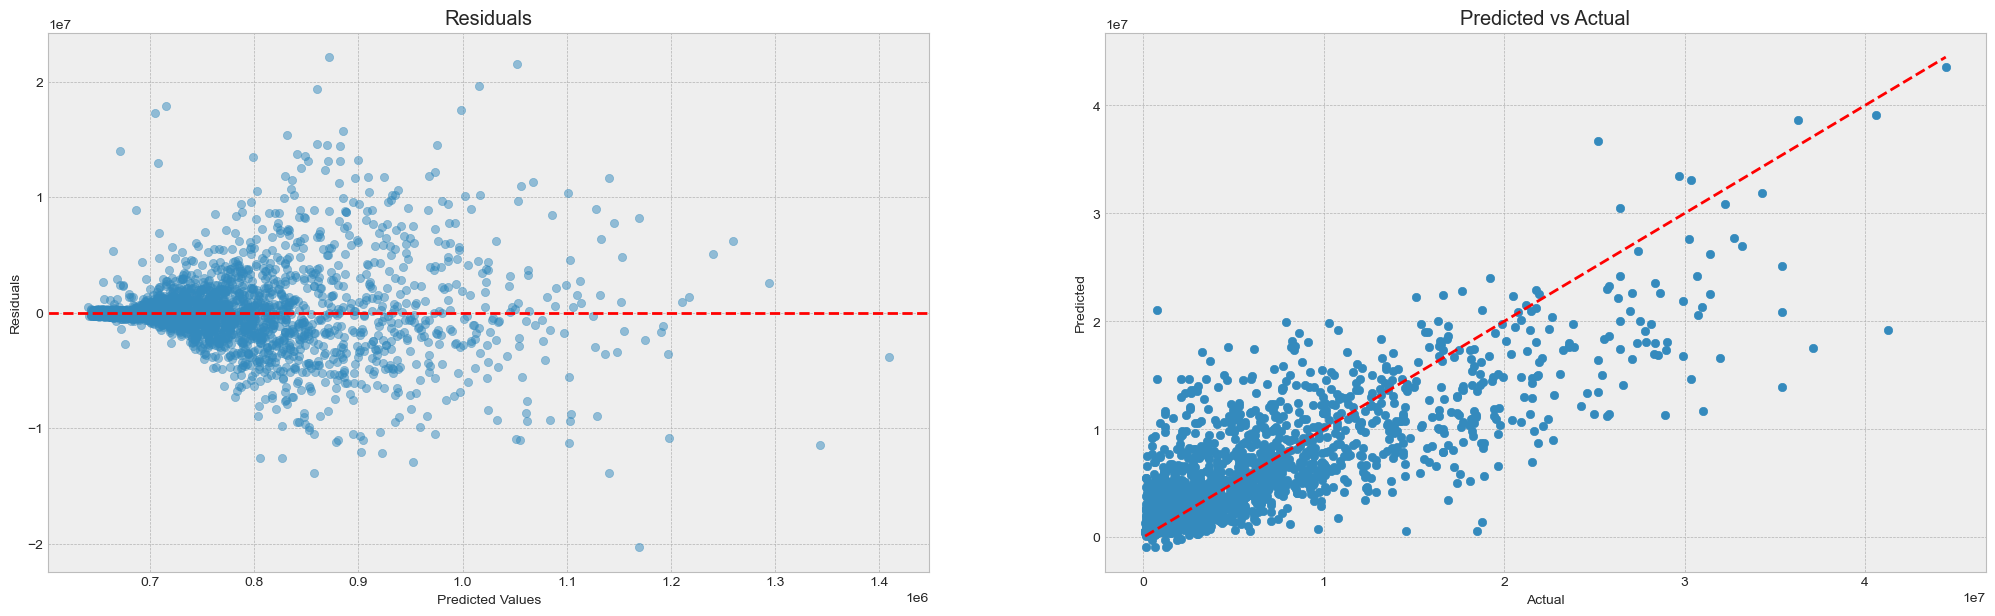

<Figure size 640x480 with 0 Axes>

In [206]:
# Residuals
residuals = y_test - y_test_pred

plt.subplots(figsize=(25, 7))

# Plot the residuals
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, marker='o', s=35, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Predicted vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')


plt.show()

# Save the figure
plt.savefig('residualsGBR.png')

- __Homoscedasticity__: The residuals seem to be randomly scattered around the zero line. This suggests that the assumption of homoscedasticity (constant variance) of the residuals is reasonably met.

- __Independence__: The residuals do not display any clear patterns (they look quite random). This suggests that the assumption of independence is not violated.

Overall, this residuals plot indicates that our model is quite good. It's doing a good job of capturing the pattern in the data.

C:\Users\Hector G. Guerrero\AppData\Local\Temp\ipykernel_10616\2343434032.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


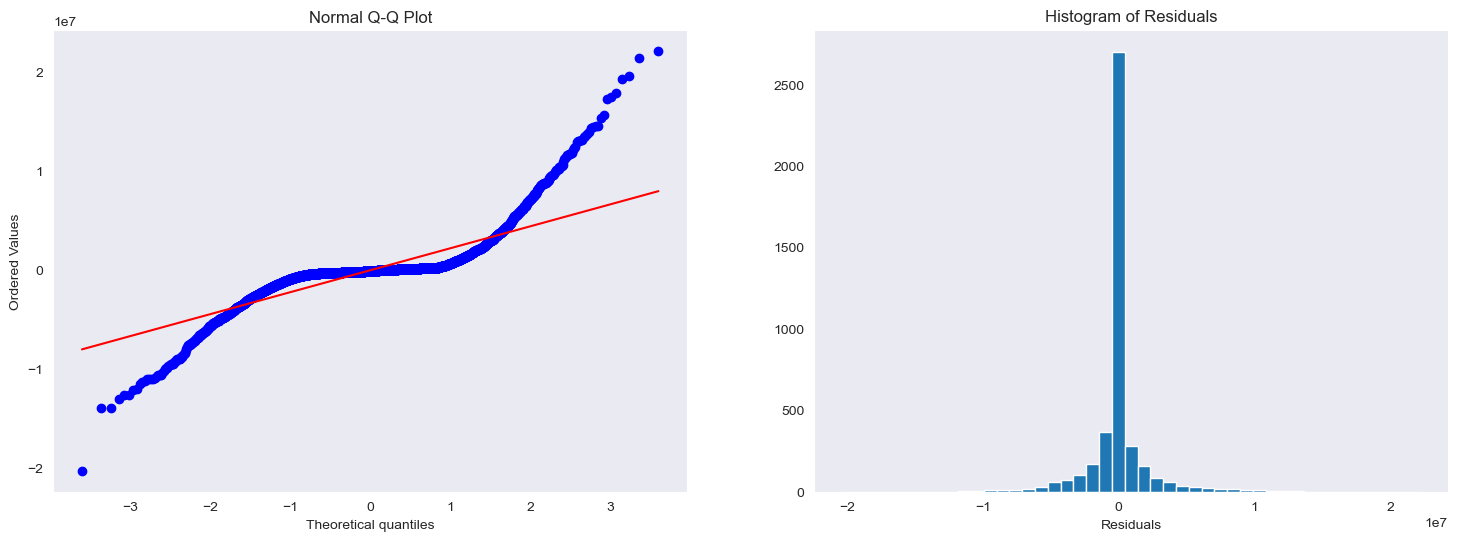

<Figure size 640x480 with 0 Axes>

In [149]:
plt.subplots(figsize=(18, 6))

plt.subplot(1, 2, 1)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")


plt.subplot(1, 2, 2)
plt.hist(residuals, bins=45)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')


plt.show()

#save plot
plt.savefig('qqplot.png')

## 5. Feature Importance and Interpretation <a id=feature-importance-and-interpretation></a>

In [202]:
# Features Importance
fitted_gb = gb_grid.best_estimator_.named_steps['model']

importances = fitted_gb.feature_importances_

# Match feature importances to the features
feature_importances = pd.Series(importances, index = X_train.columns)

# Sort the feature importances
feature_importances = feature_importances.sort_values(ascending = False)

# Print out the feature importances
feature_importances

career_WAR                        0.245907
Career_HR                         0.243821
career_TB                         0.197840
career_length                     0.065875
Career_SO                         0.036679
age                               0.031179
Career_IBB                        0.027439
Career_R                          0.020133
career_PA                         0.018450
Career_BB                         0.017073
career_RBI                        0.015642
Career_H                          0.013190
teamName_New York Yankees         0.008436
POS_SS                            0.004727
POS_C                             0.004563
teamName_Detroit Tigers           0.004210
POS_OF                            0.003382
teamName_Boston Red Sox           0.002771
teamName_Baltimore Orioles        0.002751
teamName_Los Angeles Angels       0.002546
teamName_Chicago Cubs             0.002248
bats_R                            0.002236
teamName_Seattle Mariners         0.001897
bats_L     

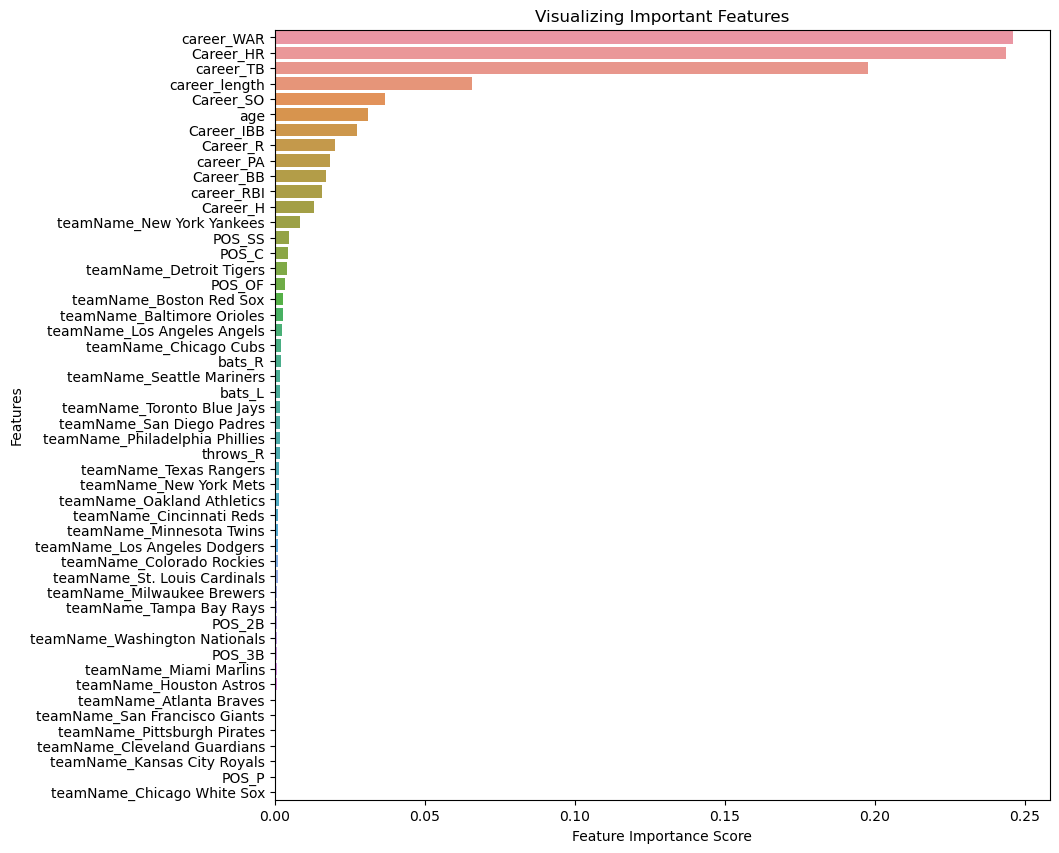

In [97]:
# Plot feature_importances
plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [194]:
# sort by descending
top_10_features = feature_importances.sort_values(ascending=False).head(10)

# Set index as row names
top_10_features = top_10_features.reset_index()

top_10_features.columns = ['Feature', 'Importance']

top_10_features

,Feature,Importance
0,career_WAR,0.245907
1,Career_HR,0.243821
2,career_TB,0.197840
3,career_length,0.065875
4,Career_SO,0.036679
5,age,0.031179
6,Career_IBB,0.027439
7,Career_R,0.020133
8,career_PA,0.018450
9,Career_BB,0.017073


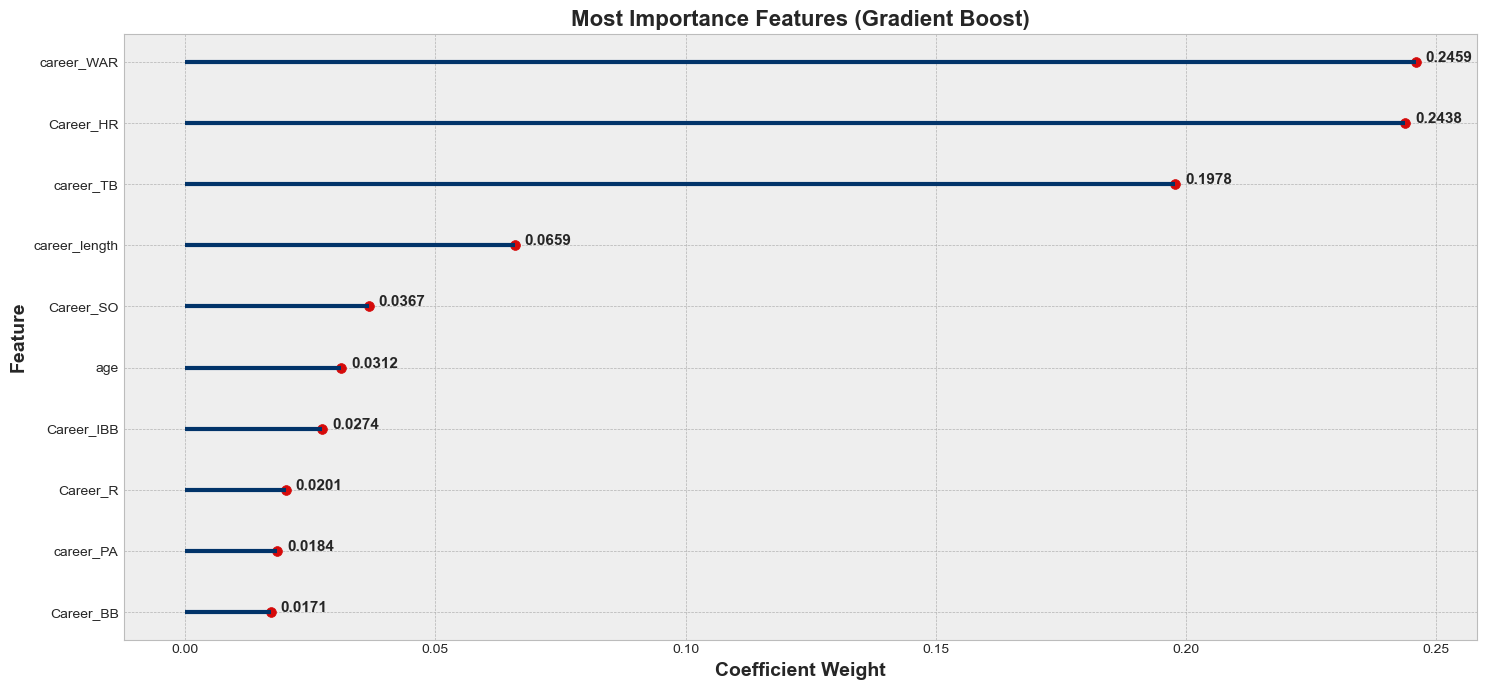

In [207]:
# plot a lollipop plot of top 15 most important features
fig, ax = plt.subplots(figsize=(15, 7))
plt.style.use('bmh')

# sort by descending
top_10_features= top_10_features.sort_values(by = 'Importance')

# plots the lines
plt.hlines(y = top_10_features['Feature'],  # feature
           xmin = 0,
           xmax = top_10_features['Importance'],  # importance
           color = '#013369', linewidth = 3)

plt.scatter(top_10_features['Importance'], # Count values
            top_10_features['Feature'],  # positions
            color='#d50a0a', 
            alpha=1, s = 50)

# annotate the scatter plot values
for idx, row in top_10_features.iterrows():
    ax.annotate(round(row['Importance'],4), (row['Importance'], row['Feature'] ), 
                weight = "bold", fontsize = 11, 
                xytext=(row['Importance'] + 0.002, row['Feature'])) # offset annotate

plt.title('Most Importance Features (Gradient Boost)', weight = "bold", fontsize = 16)
plt.ylabel('Feature', weight = "bold", fontsize = 14)
plt.xlabel('Coefficient Weight', weight = "bold", fontsize = 14)

plt.tight_layout()
plt.show()

# save the plot
fig.savefig('feature_importance_GBR.png', dpi=300, bbox_inches='tight')

The feature importance of the Gradient Boosting model shows which features are the most influential in predicting a player's salary. The most important features are `career_WAR`, `Career_HR`, and `career_TB`.

- __career_WAR:__ This is the most important feature according to the model. It suggests that a player's Wins Above Replacement throughout their career is the most influential factor in determining their salary.

- __Career_HR and career_TB__: These are the second and third most important features respectively. They represent a player's Home Runs and Total Bases in their career. This implies that players who have hit more home runs and achieved more total bases throughout their career tend to have higher salaries, which makes sense given that these are indicators of a player's offensive performance.

- __career_length and age__: These features are also quite important. This suggests that more experienced players, and older players, tend to earn higher salaries.

- __Career_SO, Career_IBB, Career_R, career_PA, Career_BB, career_RBI, Career_H__: These statistics from the player's career also play an important role in their salary.

The less important features appear towards the bottom of the plot. These include the player's position (POS), their batting hand (bats), their throwing hand (throws), and their team (teamName). These features have some influence on the salary, but much less than the player's performance statistics.

## 6. Conclusion <a id='conclusion'></a>

In this notebook, we explored various regression models to predict baseball player salaries using features such as career statistics and team affiliations. The models included linear regression, ridge regression, lasso regression, decision tree, random forest, and gradient boosting regressor. The gradient boosting regressor emerged as the best model with the lowest RMSE and highest R^2 values, indicating its superior predictive performance. Feature importance analysis revealed 'career_WAR', 'Career_HR', and 'career_TB' as the most influential features. The residuals were inspected for normality and homoscedasticity using plots and QQ plots, helping to verify the model's assumptions and reliability. This work provides a robust machine learning approach to understanding and predicting baseball player salaries. It demonstrates the value of model comparison, hyperparameter tuning, and diagnostic plots in building and evaluating predictive models.